# 0. Loading libraries and Classes

In [352]:
# Import pandas, numpy, seaborn and matplotlib libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Import train_test_split to separate train and test set
from sklearn.model_selection import train_test_split

# Import MissingIndicator and SimpleImputer from impute module
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer

In [276]:
# Set the parameters and the style for plotting
params = {'figure.figsize':(12,8),
         'axes.labelsize':13,
         'axes.titlesize':16,
         'xtick.labelsize':11,
         'ytick.labelsize':11
         }
plt.rcParams.update(params)
sns.set_style("whitegrid")

We'll be using Titanic dataset to explore missing data in this notebook.

In [277]:
# Load the dataset 'Data/titanic_data.csv' and store it in variable data
data = pd.read_csv('Data/titanic_data.csv')
# Get the first 5 rows
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. First look at the missing values

We can use Pandas chained `isnull().sum()` function to detect missing values.

In [278]:
# Get the total number of missing values using
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that three columns contain missing values: 'Age', 'Cabin' and 'Embarked'. If we want to compute the proportion of missing values, we can use `.mean()` function and plot the proportion using barplot.

In [351]:
# Compute the proportion of missing values
percentage = data.isnull().mean()*100
percentage

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

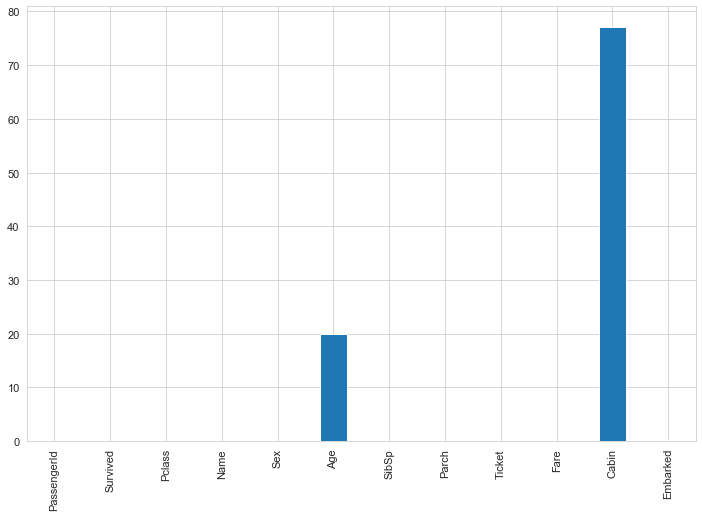

In [350]:
# Plot barchart
percentage.plot(kind='bar');

If we want to visualize the location of missing values, we can use `seaborn's heatmap` that tells us where the missing values occur. We set parameter `cbar = False` as the color bar does not need to be drawn.

Such a visualization has a benefit which people usually do not realize. Imagine that you just produce sums or in other words amounts of missing values in the dataset. Remember that descriptive statistics might reveal less than what visualisation does. This is also true for missing values. You might be able to spot, for example, **that missing values in two columns have similar or same pattern**. 

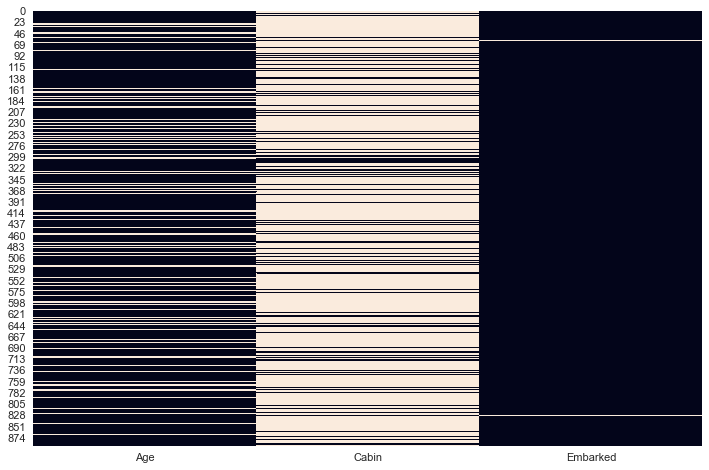

In [281]:
# Visualize only those three columns that contain missing values
data_copy = data[['Age','Cabin','Embarked']]
sns.heatmap(data_copy.isnull(), cbar = False);

# 2. Concepts of missing values

According to Rubin's theory $^{1}$, every data point has some probability of being missing in the dataset. The process that governs these probabilities is called **the missing data mechanism**. 

## 2.1 MNAR: Missing data Not At Random

MNAR means that the probability of being missing varies for reasons that are unknown to us. Let's look at the columns 'Age' and 'Cabin' in which passengers were traveling. We found out that the column 'Cabin' contains approximately 77% missing values, the column 'Age' almost 20% missing values. 

The age or cabin could not be established for people who did not survive that night. We assume that survivors were asked for such information. But can we infer this when we look at the data? In this case, we expect that observations with people who did not survive should have more missing values. Let's find out.

*Note: Below is a cool functionality of pandas. The method is called query and allows you to really simply subset your data. Of course you could also solve with the traditional functionality which you already learned, I just wanted to make use of the opportunity.*

### 2.1.1 Diagnosing Missing Data

In [282]:
# Filter the dataset based on people who survived
survived = data.query('Survived == 1')
survived

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,NaN,C
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [283]:
# Print the percentage of missing values in column 'Cabin' for people who survived
print('The percentage of missing values: {0:.1f} %'.format(survived['Cabin'].isna().mean()*100))

The percentage of missing values: 60.2 %


In [284]:
# Filter the dataset based on people who did not survived
not_survived = data.query('Survived == 0')
not_survived

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [285]:
# Print the percentage of missing values in column 'Cabin' for people who did not survive
print('The percentage of missing values: {0:.1f} %'.format(not_survived['Cabin'].isna().mean()*100))

The percentage of missing values: 87.6 %


The output we obtained is the same as we expected. There is more missing values(approximately 87.6%) for people who did not survive compared to the survivals (60.2 %).

In [286]:
# TASK 1 >>>> Now it's your turn to explore the column 'Age' in the same way 
#             and think about whether the values are missing not at random
print(survived['Age'].isna().mean()*100)
print(not_survived['Age'].isna().mean()*100)

15.204678362573098
22.768670309653917


In the previous notebook, we've filled in missing values using Pandas `fillna() method`. We can specify a scalar value, method such as backward fill ('bfill'), or forward fill ('ffill'), or statistic such as mean, median, or mode of the particular column within this method. If we want to replace missing data with 'bfill' method or 'ffill' method and the previous or the next value is not present, the missing values remain present after the imputation. Also, be careful when filling in missing values with the mean if your data have outliers because the mean is affected by them.

This approach of filling missing values should be sufficient if you will use the dataset for simple analysis. However remember what we discussed. As soon as we want to build a robust pipeline, for example, for Machine Learning, we need to be able to save the state. This of course means that the Pandas functionality does not come in handy. We would need to be manually saving the state of *"mean which should be imputed"* somewhere. 

Luckily for us, scikit-learn offers a handy alternative in forms of **missing indicator** and **simple imputer**. Both of these are saving the state so that we can easily make those part of our robust pipeline. Let's now take a look at these two.


------

**Simple Imputer and Missing Indicator**

`scikit learn` offers transformers for Univariate and Multivariate imputation of missing values. You can read more in the [documentation](https://scikit-learn.org/stable/modules/impute.html). Now we demonstrate the usability of `SimpleImputer()` class from the impute module. You can specify several parameters, such as the placeholder (np.nan) for missing values, the imputation strategy, or the value used to replace missing values. Find more [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).



**Before we impute the missing values**, it is useful to mark missing values to preserve the information about which values had been missing. We can use `MissingIndicator`, which transforms the dataset into a binary variables indicating the presence of missing values (these binary variables will be added to the original training set). See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator) for MissingIndicator.

In essence the idea behind missing indicator is that we **preserve extra information** for our model, which is that the value was missing. We are hoping that the model might pick up a pattern herein which we missed, for example when exploring the missing values.

Let's split our data into training and testing set, mark missing values, and fill in those using SimpleImputer.

In [287]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(data[['Pclass', 'Name', 'Sex', 'Age', 'SibSp',
                                                        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']], 
                                                    data['Survived'],
                                                    test_size = 0.3,
                                                    random_state = 42) 
# Get the shape 
X_train.shape, X_test.shape

((623, 10), (268, 10))

In [288]:
# Get the number of missing values
X_train.isnull().sum()

Pclass        0
Name          0
Sex           0
Age         124
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       484
Embarked      1
dtype: int64

### 2.1.2 Missing Indicator
We'll use Missing indicator to mark missing values by setting parameters `features = 'missing-only'` (by default). If we want to create binary variables for all features, we set parameter `features = 'all'`.

In [289]:
# Create MissingIndicator object
missing_indicator = MissingIndicator(features = 'missing-only')

In [290]:
# Fit X_train with missing_indicator 
missing_indicator.fit(X_train)

MissingIndicator()

In [291]:
# Get the features with missing values
missing_indicator.features_

array([3, 8, 9], dtype=int64)

With `.features_` attribute, we get feature names or the indices of features containing missing values. 

In [292]:
# Get the features names
X_train.columns[missing_indicator.features_]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

Since the transformation of X_train returns boolean, we create a new variable to store the output. After that, we concatenate it to the original X_train.

In [293]:
# Transform X_train using missing_indicator and store the output to X_missing
X_train_missing = missing_indicator.transform(X_train)

In [294]:
# Display the output
X_train_missing

array([[False, False, False],
       [ True,  True, False],
       [False,  True, False],
       ...,
       [False,  True, False],
       [False, False, False],
       [False, False, False]])

Now we concatenate X_train_missing boolean variables to the original X_train. To distinguish which boolean variable belongs to the original feature in X_train, we create new names (otherwise, boolean variables names will be labeled as 0,1 and 2). X_train_missing array needs to be converted using `pd.DataFrame`, since only Series and DataFrame objects are valid within `concat()` method.

In [295]:
# Create new column names for boolean variables
# Create an empty list to store new names
indicator_name = []
# Iterate over the features with missing values
for column in X_train.columns[missing_indicator.features_]:
    column_name = column + '_Missing'
    # Append new names to the indicator_name list
    indicator_name.append(column_name)

In [296]:
# Concatenate the original X_train and X_train_missing along the columns
# Reset the index in X_train and convert X_train_missing to pandas DataFrame 
# Assign new column names stored in indicator_name to columns parameter
X_train = pd.concat([X_train.reset_index(), pd.DataFrame(X_train_missing, columns = indicator_name)], axis = 1)
X_train

,index,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Missing,Cabin_Missing,Embarked_Missing
0,445,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S,False,False,False
1,650,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S,True,True,False
2,172,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S,False,True,False
3,450,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S,False,True,False
4,314,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,106,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S,False,True,False
619,270,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S,True,True,False
620,860,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S,False,True,False
621,435,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S,False,False,False


In [297]:
# TASK 2 >>>>> Repeat the process for X_test data
# Transform X_test data using missing_indicator and store it to variable X_test_missing
X_test_missing = missing_indicator.transform(X_test)

In [298]:
# TASK 2 >>>>> Concatenate the original X_test and X_test_missing along the columns in the same way as we did for X_train
# Assign it to the original X_test
X_test = pd.concat([X_test.reset_index(), pd.DataFrame(X_test_missing, columns = indicator_name)], axis = 1)
# Display X_test to see the result
X_test

,index,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Missing,Cabin_Missing,Embarked_Missing
0,709,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,True,True,False
1,439,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S,False,True,False
2,840,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S,False,True,False
3,720,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S,False,True,False
4,39,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,821,3,"Lulic, Mr. Nikola",male,27.0,0,0,315098,8.6625,NaN,S,False,True,False
264,633,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,True,True,False
265,456,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S,False,False,False
266,500,3,"Calic, Mr. Petar",male,17.0,0,0,315086,8.6625,NaN,S,False,True,False


### 2.1.3 Simple Imputer
Now we'll impute missing values of column Age using Simple Imputer. We specify the placeholder for missing values (np.nan) and strategy = 'mean' (this strategy is by default, so it is okay if you don't explicitly specify it within the class).

In [299]:
# Create SimpleImputer object for imputing missing values with mean strategy
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

In [300]:
# Fit column Age in X_train
imputer.fit(X_train[['Age']])

SimpleImputer()

In [301]:
# To see the mean value that will be used for imputing we can use .statistics_ attribute
imputer.statistics_

array([29.25635271])

In [302]:
# Transform column Age in X_train
X_train['Age'] = imputer.transform(X_train[['Age']])

In [303]:
# Get the total number of missing values in column Age to see whether these values have been replaced
X_train['Age'].isnull().sum()

0

In [304]:
# TASK 3 >>>>> Repeat the imputing also for colum Age in X_test data
X_test['Age'] = imputer.transform(X_test[['Age']])
# # Get the total number of missing values in column Age to see whether these values have been replaced
X_train['Age'].isnull().sum()

0

## 2.2 MCAR: Missing data Completely At Random 

When data are missing completely at random, the probability of being missing is the same for all observations in the dataset, i.e., the cause of the missing data is unrelated to the data.

Let's take as an example column 'Embarked' and its missing values.

In [305]:
# Get the rows where the values in 'Embarked' column are missing
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Mrs. Stone was traveling in the first class with her maid Miss. Amelie Icard. They occupied the same Cabin B28, but the data about the port of embarkation are missing. But we can not tell if the Embarked variable depends on any other variable. We can also see that these women have survived, so we assume that they were asked for that information. It could happen that this information was lost when this dataset was created. The probability of losing this information is the same for every person on the Titanic. However, it would probably be impossible to prove. 

For curiosity: You can find out more information about Mrs. Stone and her maid [here](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html). There is also information about the port of embarkation in this article.  

-----

We can impute missing values also in case of categorical variables that have values stored as strings. Let's impute missing values of Embarked column in X_train data. We set `strategy = constant` that allows us to specify the `fill_value` used to replace missing values. This can be used with strings or numeric data as well. The second option for strategy is `most_frequent` when the missing values will be replaced using the most frequent column value.

In [306]:
# Create SimpleImputer object and store it to variable imputer_cat
imputer_cat = SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = 'S')

In [307]:
# Fit column Embarked in X_train
imputer_cat.fit(X_train[['Embarked']])

SimpleImputer(fill_value='S', strategy='constant')

In [308]:
# Transform column Embarked in X_train
X_train['Embarked'] = imputer_cat.transform(X_train[['Embarked']])

In [309]:
# # Get the total number of missing values in column Embarked to see whether these values have been replaced
X_train['Embarked'].isnull().sum()

0

In [310]:
# TASK 4 >>>>> Repeat the imputing also for column Embarked in X_test data
X_test['Embarked'] = imputer_cat.transform(X_test[['Embarked']])
# Get the total number of missing values in column Embarked to see whether these values have been replaced
X_test['Embarked'].isnull().sum()

0

## 2.3 MAR: Missing At Random

We can say that the data are missing at random if the probability of being missing is the same only within groups defined by the observed data. An example of this case is when we take a sample from a population. The probability to be included depends on some known property. For example, when placed on a soft surface, a weighing scale may produce more missing values than when placed on a hard surface.

### TASK

In this task, you will be using the Avocado dataset. You will impute numeric missing values in column 'Small Bags' with the median value using Simple Imputer. The second task is to impute missing values in the column 'Region' with the most frequent string value of this column using Simple Imputer.

In [330]:
# Load the dataset 'Data/avocado_missing.csv' and store it to variable avocado
avocado = pd.read_csv('Data/avocado_missing.csv')
# Print the first 5 rows
avocado.head()

,Date,AveragePrice,Total Volume,Small Hass Avocado,Large Hass Avocado,Extra Large Hass Avocado,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13061.10,537.36,0.0,organic,2015,Southeast
1,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,0.00,0.0,organic,2015,NaN
2,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
3,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,NaN,3660.38,0.0,conventional,2015,Pittsburgh
4,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,186.67,187.68,0.0,organic,2015,Boise


In [331]:
# TASK >>>> Print the total number of missing values
avocado.isnull().sum()

Date                           0
AveragePrice                   0
Total Volume                   0
Small Hass Avocado             0
Large Hass Avocado             0
Extra Large Hass Avocado       0
Small Bags                  3650
Large Bags                     0
XLarge Bags                    0
type                           0
year                           0
region                      1825
dtype: int64

In [313]:
# TASK >>>> Create SimpleImputer object and store it in variable imputer_median
# Specify that you want to impute median value
imputer_median = SimpleImputer(missing_values = np.nan, strategy = 'median')

In [314]:
# TASK >>>> Fit column 'Small Bags' using imputer_median 
imputer_median.fit(avocado[['Small Bags']])

SimpleImputer(strategy='median')

In [315]:
# Print the median value that will be used to replacing missing values
imputer_median.statistics_

array([26811.45])

In [316]:
# TASK >>>> Transform column 'Small Bags' using imputer_median
# Assign the transformation to avocado['Small Bags']
avocado['Small Bags'] = imputer_median.transform(avocado[['Small Bags']])

In [317]:
# TASK >>>> Create SimpleImputer object and store it in variable imputer_freq
# Specify that you want to impute the most frequent value
imputer_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

In [318]:
# TASK >>>> Fit column 'region' using imputer_freq
imputer_freq.fit(avocado[['region']])

SimpleImputer(strategy='most_frequent')

In [319]:
# Print the most frequent value that will be used to replacing missing values
imputer_freq.statistics_

array(['SouthCarolina'], dtype=object)

In [320]:
# TASK >>>> Transform column 'region' using imputer_freq
# Assign the transformation to avocado['region']
avocado['region'] = imputer_freq.transform(avocado[['region']])

In [321]:
# Print the total number of missing values to see whether the missing values have been replaced
avocado.isnull().sum()

Date                        0
AveragePrice                0
Total Volume                0
Small Hass Avocado          0
Large Hass Avocado          0
Extra Large Hass Avocado    0
Small Bags                  0
Large Bags                  0
XLarge Bags                 0
type                        0
year                        0
region                      0
dtype: int64

# 3. Read only - Column Transformer

Commonly, preparing data for machine learning models often involve several transformations such as imputing missing values, scaling numerical values, or encoding categorical features applied for particular columns. `scikit learn` offers `ColumnTransformer` class that is used to apply different transformers to columns. This Column transformer can be chained with Pipelines along with machine learning model. You can read more about ColumnTransformer [here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

# Appendix

$^{1}$ Inference and missing data, DONALD B. RUBIN, Biometrika, Volume 63, Issue 3, December 1976, Pages 581–592

Data source: 

Titanic dataset: https://www.kaggle.com/hesh97/titanicdataset-traincsv

Data license: CC0: Public Domain

Avocado dataset: https://www.kaggle.com/neuromusic/avocado-prices

Data license: Database: Open Database